## 套件匯入

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import networkx as nx
import tensorflow as tf
import pandas as pd
import pickle
import re
import string
import zhon
import nltk
from docx import Document
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
from tensorflow.python.util import deprecation
from zhon.hanzi import punctuation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

## 讀取檔案

In [2]:
f = open('C:/Users/sefx5/Downloads/議程附件4-總綱小組第1-7次諮詢會議紀錄(稿).docx','rb')
document = Document(f)

## 匯入字典

In [3]:
# 只需執行一次
# data_utils.download_data("./")

In [4]:
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

## 截取會議内容與參與會議人員（本院 / 非本院）

In [5]:
sentence_list,ppl_list,save_content = [],[],False
for para in document.paragraphs:
    if save_content:
        if para.text != '' or para.text != '\n':
            sentence_list.append(para.text)
    if para.text[:4] in ['出席人員','請假人員']:
        ppl_list.append(para.text[5:])
    if para.text == '發言紀要：':
        save_content = True
    if para.text[:5] == '決  議：':
        save_content = False

In [ ]:
# 將人員列表分爲：
## 1.全體人員 -> final_ppl
## 2.本院人員 -> final_in_ppl
## 3.非本院人員 -> final_out_ppl

in_ppl,out_ppl = [],[]
for each in ppl_list:
    for ppl_ in each.split('、'):
        if ppl_[:2] == '本院' or ppl_[-3:] == '研究員' or ppl_[-2:] == '助理':
            in_ppl.append(ppl_)
        else:
            out_ppl.append(ppl_)

In [ ]:
# 確保人員名單為唯一值
in_ppl = list({each : 1 for each in in_ppl}.keys())
out_ppl = list({each : 1 for each in out_ppl}.keys())

In [ ]:
in_pos = pos(in_ppl)
in_ner = ner(in_ppl,in_pos)
print(in_ppl)

In [ ]:
final_in_ppl = []
for no,each_ppl in enumerate(in_ner):
    if len(each_ppl) == 0:
        final_in_ppl.append(input(in_ppl[no]+':'))
    else: final_in_ppl.append(list(each_ppl)[0][3])
final_in_ppl = list(set(final_in_ppl))

In [ ]:
out_pos = pos(out_ppl)
out_ner = ner(out_ppl,out_pos)
print(out_ppl)

In [ ]:
final_out_ppl = []
for no,each_ppl in enumerate(out_ner):
    final_out_ppl.append(input(out_ppl[no]+':'))
final_out_ppl = list(set(final_out_ppl))

In [ ]:
final_ppl = final_in_ppl+final_out_ppl

## 暫存 Pickle 檔

In [ ]:
# 輸出名單
outfile = open('attendance_list.pkl','wb')
pickle.dump([final_in_ppl,final_out_ppl,final_ppl],outfile)
outfile.close()
print('完成儲存')

In [6]:
# 輸入名單
infile = open('attendance_list.pkl','rb')
new_dict = pickle.load(infile)
final_in_ppl,final_out_ppl,final_ppl = new_dict[0],new_dict[1],new_dict[2]
print('完成寫入')

完成寫入


## 觀察資料與剖析

In [7]:
#过滤中英文标点符号、字母、数字
def filter_punc(desstr:list,restr=''):
    pattern = re.compile("[%s]+" % string.punctuation + "|[%s]+" % zhon.hanzi.punctuation + "|[%s]+" % 'a-zA-Z0-9') #匹配中英文符号及字母数字
    filter_ = [pattern.sub(restr,each_sentence) for each_sentence in desstr]
    return filter_

In [8]:
sentence_list

['一、社團法人臺中市聽障生活無障礙發展協會潘信宏執行長：',
 '    (一)議程第17頁「2.臺灣手語」的部分，啟聰學校有溝通訓練是否可取代臺灣手語的學習？啟聰學校是否也按固定課程來安排臺灣手語，啟聰學校的溝通訓練以口手語為主，而非自然手語(即臺灣手語)，溝通訓練是以手勢來教中文「Sign Chinese」。',
 '    (二)臺灣目前的教育體系沒有在教臺灣手語，啟聰學校也沒有。以實際經驗為例，啟聰學校畢業生工作發現：他們以為用來溝通的文字手語就是臺灣手語，語言已經快要消失了，年輕人也不會臺灣手語，因此建議啟聰學校的溝通訓練不能取代臺灣手語的學習。',
 '二、社團法人臺中市聽障生活無障礙發展協會潘信宏執行長：啟聰學校也要有足夠的臺灣手語師資，目前校內的老師們也以為自己教的就是臺灣手語。',
 '三、本院楊秀菁助理研究員：目前將臺灣手語排除只有特殊教育學生才要學的，一般學生在學校教育內只要有意願也可以學習，關於啟聰學校，則由特殊教育法的課綱去專門規範。',
 '四、國立臺灣師範大學公民教育與領導學系博士班吳律德先生：附件4第38頁「八、附則第四項」是否應增加文字去強調臺灣手語跟自然手語的不同？',
 '五、臺灣教師聯盟李川信顧問：',
 '    (一)閩東語，跟福州話很接近，有部分語詞不同，是否使用閩東語詞建議應斟酌。',
 '    (二)附件4第23頁：《國家語言發展法》的規範延伸很複雜，學校部定課程小一到小六只有一節課，只開一門語言課程就會排擠到其他的，如閩南區學校想選閩南語卻缺乏機會，因可能被閩東語或其他語言取代。小一到小六本來學習母語(閩南、客家、原住民語等)，以前還沒有新住民語、臺灣手語。現在若把新住民語、臺灣手語排進部定課程來，可能會排擠到原來的語言課程。新住民子女若不選擇閩南、客家語言，無法與臺灣主流文化互相包容，建議將新住民語言列為國中或高中選修的外語、第二外語。',
 '   六、本院課程及教學研究中心李文富主任：回應李川信顧問(1)閩東語一詞是按照《國家語言發展法》規定。',
 '   七、本院楊秀菁助理研究員：文化部有正式文件將閩東語文納入國家語言，文化部目前也有在做國家語言範疇、名稱的研究，未來若研究有對名稱做修改，會遵照文化部的修訂，因此目前沿用「閩東語文」。',
 '   八、本院課程及教學研究中心李文富主任：回應李川信顧問

In [9]:
# 清整中英文标点符号、字母、数字
filter_ = filter_punc(sentence_list)

In [10]:
filter_

['一社團法人臺中市聽障生活無障礙發展協會潘信宏執行長',
 '    一議程第頁臺灣手語的部分啟聰學校有溝通訓練是否可取代臺灣手語的學習啟聰學校是否也按固定課程來安排臺灣手語啟聰學校的溝通訓練以口手語為主而非自然手語即臺灣手語溝通訓練是以手勢來教中文 ',
 '    二臺灣目前的教育體系沒有在教臺灣手語啟聰學校也沒有以實際經驗為例啟聰學校畢業生工作發現他們以為用來溝通的文字手語就是臺灣手語語言已經快要消失了年輕人也不會臺灣手語因此建議啟聰學校的溝通訓練不能取代臺灣手語的學習',
 '二社團法人臺中市聽障生活無障礙發展協會潘信宏執行長啟聰學校也要有足夠的臺灣手語師資目前校內的老師們也以為自己教的就是臺灣手語',
 '三本院楊秀菁助理研究員目前將臺灣手語排除只有特殊教育學生才要學的一般學生在學校教育內只要有意願也可以學習關於啟聰學校則由特殊教育法的課綱去專門規範',
 '四國立臺灣師範大學公民教育與領導學系博士班吳律德先生附件第頁八附則第四項是否應增加文字去強調臺灣手語跟自然手語的不同',
 '五臺灣教師聯盟李川信顧問',
 '    一閩東語跟福州話很接近有部分語詞不同是否使用閩東語詞建議應斟酌',
 '    二附件第頁國家語言發展法的規範延伸很複雜學校部定課程小一到小六只有一節課只開一門語言課程就會排擠到其他的如閩南區學校想選閩南語卻缺乏機會因可能被閩東語或其他語言取代小一到小六本來學習母語閩南客家原住民語等以前還沒有新住民語臺灣手語現在若把新住民語臺灣手語排進部定課程來可能會排擠到原來的語言課程新住民子女若不選擇閩南客家語言無法與臺灣主流文化互相包容建議將新住民語言列為國中或高中選修的外語第二外語',
 '   六本院課程及教學研究中心李文富主任回應李川信顧問閩東語一詞是按照國家語言發展法規定',
 '   七本院楊秀菁助理研究員文化部有正式文件將閩東語文納入國家語言文化部目前也有在做國家語言範疇名稱的研究未來若研究有對名稱做修改會遵照文化部的修訂因此目前沿用閩東語文',
 '   八本院課程及教學研究中心李文富主任回應李川信顧問目前課綱小學階段新住民語是列為部定課程之一國高中階段未規範國高中學校若覺得有必要可在校定課程開設新住民語',
 '九國立政治大學政治學系廖浩翔先生',
 '    一十二年國民基本教育身心障礙相關之特殊需求領域課程綱要中所謂溝通訓練

In [11]:
pos_ = pos(filter_)
ner_ = ner(filter_,pos_)
ner_

[{(5, 6, 'GPE', '臺')},
 {(7, 9, 'ORDINAL', '第頁'), (30, 32, 'GPE', '臺灣'), (52, 54, 'GPE', '臺灣')},
 {(18, 20, 'GPE', '臺灣'),
  (62, 64, 'GPE', '臺灣'),
  (81, 83, 'GPE', '臺灣'),
  (102, 104, 'GPE', '臺灣')},
 {(5, 6, 'GPE', '臺'),
  (21, 22, 'PERSON', '宏'),
  (35, 37, 'GPE', '臺灣'),
  (58, 60, 'GPE', '臺灣')},
 {(0, 1, 'CARDINAL', '三'), (3, 6, 'PERSON', '楊秀菁'), (14, 16, 'GPE', '臺灣')},
 {(0, 1, 'CARDINAL', '四'),
  (3, 4, 'GPE', '臺'),
  (21, 24, 'PERSON', '吳律德'),
  (30, 31, 'CARDINAL', '八'),
  (33, 35, 'ORDINAL', '第四'),
  (46, 48, 'GPE', '臺灣')},
 {(0, 1, 'CARDINAL', '五'), (7, 9, 'PERSON', '李川')},
 {(26, 27, 'GPE', '閩')},
 {(4, 5, 'CARDINAL', '二'),
  (7, 9, 'ORDINAL', '第頁'),
  (31, 32, 'CARDINAL', '一'),
  (34, 35, 'CARDINAL', '六'),
  (37, 38, 'CARDINAL', '一'),
  (42, 43, 'CARDINAL', '一'),
  (57, 58, 'GPE', '閩'),
  (76, 77, 'GPE', '閩'),
  (90, 91, 'CARDINAL', '六'),
  (97, 98, 'GPE', '閩'),
  (115, 117, 'GPE', '臺灣'),
  (127, 129, 'GPE', '臺灣'),
  (160, 161, 'GPE', '閩'),
  (169, 171, 'GPE', '臺灣'),
  (199,

In [13]:
# 完成斷詞
ws_ = ws(filter_)
print(ws_,end = '')

[['一', '社團', '法人', '臺中市', '聽障', '生活', '無', '障礙', '發展', '協會', '潘信宏', '執行長'], ['    ', '一', '議程', '第', '頁', '臺灣', '手語', '的', '部分', '啟', '聰', '學校', '有', '溝通', '訓練', '是否', '可', '取代', '臺灣', '手語', '的', '學習', '啟', '聰', '學校', '是否', '也', '按', '固定', '課程', '來', '安排', '臺灣', '手語', '啟', '聰', '學校', '的', '溝通', '訓練', '以', '口手語', '為主', '而', '非', '自然', '手語', '即', '臺灣', '手語', '溝通', '訓練', '是', '以', '手勢', '來', '教', '中文', ' '], ['    ', '二', '臺灣', '目前', '的', '教育', '體系', '沒有', '在', '教', '臺灣', '手語', '啟', '聰', '學校', '也', '沒有', '以', '實際', '經驗', '為', '例啟', '聰', '學校', '畢業生', '工作', '發現', '他們', '以為', '用來', '溝通', '的', '文字', '手語', '就', '是', '臺灣', '手語', '語言', '已經', '快要', '消失', '了', '年輕人', '也', '不會', '臺灣', '手語', '因此', '建議', '啟', '聰', '學校', '的', '溝通', '訓練', '不能', '取代', '臺灣', '手語', '的', '學習'], ['二', '社團', '法人', '臺中市', '聽障', '生活', '無', '障礙', '發展', '協會', '潘信宏', '執行長', '啟', '聰', '學校', '也', '要', '有', '足夠', '的', '臺灣', '手語', '師資', '目前', '校', '內', '的', '老師', '們', '也', '以為', '自己', '教', '的', '就', '是', '臺灣', '手語'], ['三', '本', '院', 

In [14]:
# 將不同發言人的内容進行歸類
speech = {}
coll_perm = False
name = ''

for each_sentence in ws_:
    for each_word in each_sentence:
        if each_word in final_ppl:
            name = each_word
            speech[name] = []
            coll_perm = True
            break
        if coll_perm:
            speech[name].append(each_word)

In [15]:
# 裝歡 Data Frame 格式
df = pd.DataFrame({'name' : list(speech.keys()) , 'sentence' : list(speech.values()) })

In [26]:
nums = [5,15,22,49,51,64,70]
for num in nums:
    print(df['name'][num])

廖浩翔
林麗玲
蔡美瑤
陳張培倫
張明旭
呂明蓁
李立彬


In [17]:
# 截取及關鍵字計算，並轉成 DataFrame
keywords_collection = sum(list(df['sentence']), [])
each_words_count = nltk.FreqDist(keywords_collection)
df_label_keyword = pd.DataFrame.from_dict(each_words_count, orient='index',columns = ['count']).sort_values(['count'], ascending = False).reset_index().rename(columns = {'index' : 'keyword'})

In [18]:
# 建立贅詞列表，作爲刪去無意義字眼
rubbish_keyword = ['之','的','    ','一','二','三','四','五','六','七','八','九','十','第','本','頁','各','與','及','院','在','應','國家','有','於','學生','新']

In [19]:
# 去除 rubbish keyword Data Frame
df_label_keyword = df_label_keyword[~df_label_keyword['keyword'].isin(rubbish_keyword)].reset_index(drop = True)

In [20]:
df_label_keyword

,keyword,count
0,課程,222
1,語文,140
2,語言,100
3,手語,66
4,本土,66
5,臺灣,62
6,學校,57
7,建議,56
8,教育,50
9,說明,47


In [21]:
# 建立一個關鍵字計算器，並導入到 df['sentence_matrix'] 中
def keyword_classification(list_):
    output = []
    for keyword in list(df_label_keyword['keyword']):
        if keyword in list_:
            count = 0
            for word in list_:
                if word == keyword:
                    count+=1
            output.append(count)
            continue
        output.append(0)
    return output
                      
df['sentence_matrix'] = df['sentence'].apply(keyword_classification)

In [22]:
df_cooc_matrix = pd.DataFrame(list(df['sentence_matrix']),columns = list(df_label_keyword['keyword'])).reset_index(drop = True)
df_cooc_matrix.head()

,課程,語文,語言,手語,本土,臺灣,學校,建議,教育,說明,...,扮演,初期,逐年,段,承受,三因,使,阻力,教授群,位階
0,0,0,7,7,0,5,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,2,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [23]:
df_cooc_matrix = df_cooc_matrix.iloc[:,:20]

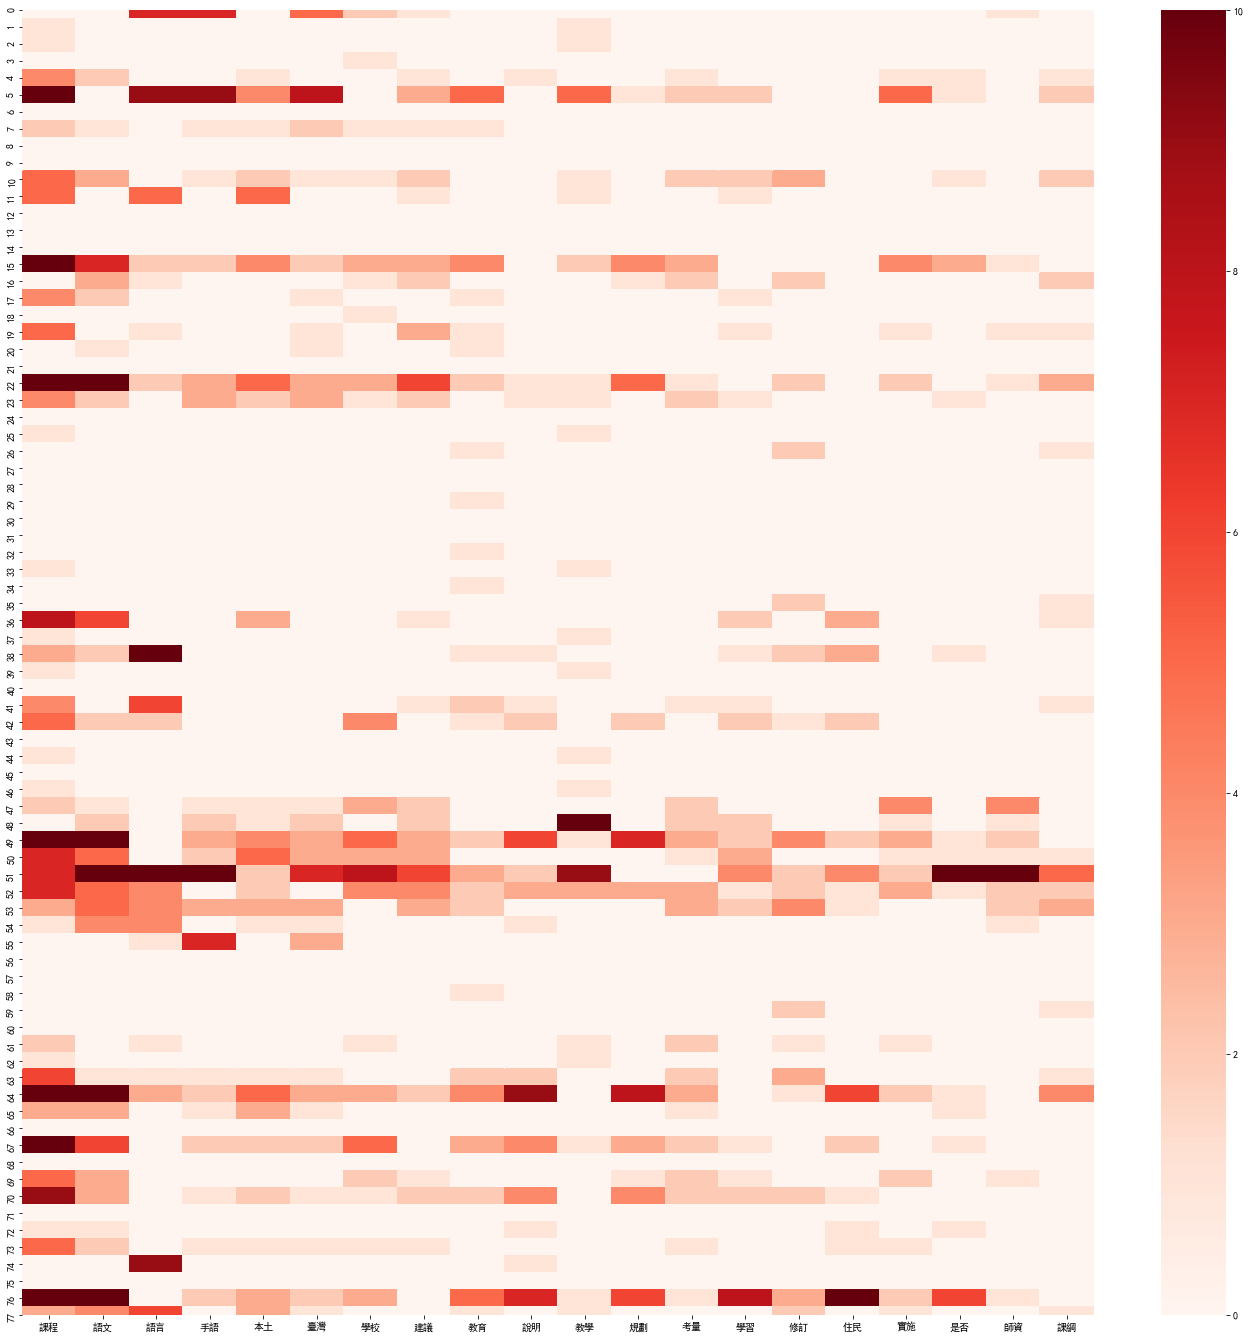

In [24]:
# 畫熱點圖驗證關鍵字的分佈情況
plt.figure(figsize=(24,24))
sn.heatmap(df_cooc_matrix,vmin = 0,vmax = 10,cmap='Reds')
plt.show()

## 共現性矩陣

In [ ]:
# 計算共現性矩陣（轉置矩陣，矩陣相乘）
co_mtx = df_cooc_matrix.T.dot(df_cooc_matrix)
co_mtx
# co_mtx = df_cooc_matrix.corr()
# co_mtx

## 資料正則化

In [ ]:
co_mtx_probability = np.floor_divide(co_mtx,df_label_keyword['count'].iloc[:20])
co_mtx_probability

In [ ]:
plt.figure(figsize=(12,12))
sn.heatmap(co_mtx_probability,vmin = 0,vmax = 8,cmap='Blues')
plt.show()

## 視覺化網絡圖

In [ ]:
# 將内容轉換成 Graph 接受的形式
high_cor_list = []
for col_index in co_mtx.columns:
    for row_index in co_mtx.columns:
        if co_mtx[col_index][row_index] > 0:
            high_cor_list.append((col_index,row_index,co_mtx.loc[col_index][row_index]))

In [ ]:
# 初始化無向圖，並將關鍵字與權重新增到 Graph 中
G = nx.Graph()
G.add_weighted_edges_from(high_cor_list)

In [ ]:
# 繪製關鍵字之網路圖
plt.figure(figsize=(24,24))
pos = nx.spring_layout(G)
nx.draw(G,pos,node_size = [val*200 for (node, val) in G.degree()],node_color = '#FFE162')
nx.draw_networkx_labels(G, pos, font_size = 30,alpha = 1)
nx.draw_networkx_edges(G, pos, edge_color = '#DDDDDD', alpha = 1,with_labels=True)
plt.show()

## 本院 vs 非本院

In [ ]:
df_in = df[~df['name'].isin(final_out_ppl)].reset_index(drop = True)
print('本院人員總數：' + str(df_in.shape[0]))
df_in

In [ ]:
df_cooc_matrix_in = pd.DataFrame(list(df_in['sentence_matrix']),columns = list(df_label_keyword['keyword'])).reset_index(drop = True)
df_cooc_matrix_in.head()

In [ ]:
# 畫熱點圖驗證關鍵字的分佈情況
df_cooc_matrix_in = df_cooc_matrix_in.iloc[:,:20]
plt.figure(figsize=(10,10))
sn.heatmap(df_cooc_matrix_in,vmin = 0,vmax = 10,cmap='Reds')
plt.show()

In [ ]:
# 計算共現性矩陣（轉置矩陣，矩陣相乘）
co_mtx_in = df_cooc_matrix_in.T.dot(df_cooc_matrix_in)
co_mtx_in

In [ ]:
plt.figure(figsize=(12,12))
sn.heatmap(co_mtx_in,vmin = 0,vmax = 8,cmap='Blues')
plt.show()

In [ ]:
df_out = df[~df['name'].isin(final_in_ppl)].reset_index(drop = True)
print('非本院人員總數：' + str(df_out.shape[0]))
df_out.head()

In [ ]:
df_cooc_matrix_out = pd.DataFrame(list(df_out['sentence_matrix']),columns = list(df_label_keyword['keyword'])).reset_index(drop = True)
df_cooc_matrix_out.head()

In [ ]:
# 畫熱點圖驗證關鍵字的分佈情況
df_cooc_matrix_out = df_cooc_matrix_out.iloc[:,:20]
plt.figure(figsize=(10,10))
sn.heatmap(df_cooc_matrix_out,vmin = 0,vmax = 10,cmap='Reds')
plt.show()

In [ ]:
# 計算共現性矩陣（轉置矩陣，矩陣相乘）
co_mtx = df_cooc_matrix_out.T.dot(df_cooc_matrix_out)
co_mtx

In [ ]:
plt.figure(figsize=(12,12))
sn.heatmap(co_mtx_probability,vmin = 0,vmax = 8,cmap='Blues')
plt.show()

In [ ]:
co_mtx_out = df_cooc_matrix_out.corr()
co_mtx_out

In [ ]:
import plotly.express as px
fig = px.scatter(co_mtx_out, x="手語", y="師資",color=co_mtx_out.index)
fig.show()

In [ ]:
fig = px.scatter(co_mtx_in, x="師資", y="手語",color=co_mtx_in.index)
fig.show()

In [ ]:
fig = px.scatter(co_mtx_in, x="課程", y="課綱",color=co_mtx_in.index)
fig.show()